### Привет!

ROC-AUC на каггле = 0.83200

### #1.Импортируем необходимые библиотеки

In [1]:
import os
import json
import pandas as pd
import datetime
import warnings
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import GridSearchCV
import xgboost
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC


%matplotlib inline

/home/oxalotl/miniconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
SEED = 10801
sns.set_style(style="whitegrid")
plt.rcParams["figure.figsize"] = 12, 8
warnings.filterwarnings("ignore")

### <left>Описание данных

Файлы:

- `sample_submission.csv`: пример файла-посылки
- `train_raw_data.jsonl`, `test_raw_data.jsonl`: "сырые" данные 
- `train_data.csv`, `test_data.csv`: признаки, созданные авторами
- `train_targets.csv`: результаты тренировочных игр

### <left>Описание признаков
   
    
Набор простых признаков, описывающих игроков и команды в целом

In [2]:
PATH_TO_DATA = "data/raw_data"

df_train_features = pd.read_csv(os.path.join(PATH_TO_DATA, 
                                             "train_data.csv"), 
                                    index_col="match_id_hash")
df_train_targets = pd.read_csv(os.path.join(PATH_TO_DATA, 
                                            "train_targets.csv"), 
                                   index_col="match_id_hash")

In [4]:
df_train_features.shape

(31698, 245)

In [5]:
df_train_features.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_stuns,d5_creeps_stacked,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,0.000000,0,0,0,0,0.00,0,0,0,0
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,...,0.000000,0,0,0,0,0.00,0,0,0,0
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,57,0,0,0,1,...,0.000000,0,0,0,0,0.00,0,0,0,0
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,119,0,3,3,5,...,8.264696,0,0,3,0,0.25,0,0,3,0
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,12,3,1,2,9,...,15.762911,3,1,0,1,0.50,0,0,3,0


Имеем ~32 тысячи наблюдений, каждое из которых характеризуется уникальным `match_id_hash` (захэшированное id матча), и 245 признаков. `game_time` показывает момент времени, в который получены эти данные. То есть по сути это не длительность самого матча, а например, его середина, таким образом, в итоге мы сможем получить модель, которая будет предсказывать вероятность победы каждой из команд в течение матча (хорошо подходит для букмекеров).

Нас интересует поле `radiant_win` (так называется одна из команд, вторая - dire). Остальные колонки здесь по сути получены из "будущего" и есть только для тренировочных данных, поэтому на них можно просто посмотреть).

In [6]:
df_train_targets.head()

,game_time,radiant_win,duration,time_remaining,next_roshan_team
match_id_hash,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,True,1154,496,NaN
6db558535151ea18ca70a6892197db41,21,True,1503,1482,Radiant
19c39fe2af2b547e48708ca005c6ae74,160,False,2063,1903,NaN
c96d629dc0c39f0c616d1949938a6ba6,1016,True,2147,1131,Radiant
156c88bff4e9c4668b0f53df3d870f1b,582,False,1927,1345,Dire


### I. <left>Наша первая модель

In [6]:
X = df_train_features.values
y = df_train_targets["radiant_win"].values.astype("int8")

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                      test_size=0.3, 
                                                      random_state=SEED)

In [9]:
%%time 


gs_rfc = GridSearchCV(RandomForestClassifier(n_jobs=-1, random_state=SEED), 
                                                  {"max_depth":[None, 1, 3, 5, 7, 10],
                                                   "n_estimators": [100, 200, 300, 500]
                                                  },
                                                 scoring='roc_auc')
gs_rfc.fit(X_train, y_train)
y_pred = gs_rfc.predict_proba(X_valid)[:, 1]

CPU times: user 2min 32s, sys: 6.7 s, total: 2min 39s
Wall time: 4min 32s


In [10]:
valid_score = roc_auc_score(y_valid, y_pred)
print("ROC-AUC score на отложенной части:", valid_score)

ROC-AUC score на отложенной части: 0.7878194337561464


In [11]:
valid_accuracy = accuracy_score(y_valid, y_pred > 0.5)
print("Accuracy score (p > 0.5) на отложенной части:", valid_accuracy)

Accuracy score (p > 0.5) на отложенной части: 0.7033648790746583


In [12]:
gs_rfc.best_params_

{'max_depth': None, 'n_estimators': 500}

### #3. <left>Кросс-валидация

Во многих случаях кросс-валидация оказывается лучше простого разбиения на test и train. Воспользуемся `ShuffleSplit` чтобы создать 5 70%/30% наборов данных.

In [8]:
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=SEED)

In [9]:
%%time
rf_model = RandomForestClassifier(n_estimators=500, max_depth=None, n_jobs=-1, random_state=SEED)
cv_scores_rf = cross_val_score(rf_model, X, y, cv=cv, scoring="roc_auc")

CPU times: user 22 µs, sys: 9 µs, total: 31 µs
Wall time: 35 µs


In [11]:
cv_scores_rf

array([0.78781943, 0.78772179, 0.78025497, 0.78549852, 0.78826719])

In [12]:
print(f"Среднее значение ROC-AUC на кросс-валидации: {cv_scores_rf.mean()}")

Среднее значение ROC-AUC на кросс-валидации: 0.7859123816496376


### <left>Что есть в json файлах?

Описание сырых данных можно найти в `train_matches.jsonl` и `test_matches.jsonl`. Каждый файл содержит одну запись для каждого матча в [JSON](https://en.wikipedia.org/wiki/JSON) формате. Его легко превратить в питоновский объект при помощи метода `json.loads`.

In [59]:
with open(os.path.join(PATH_TO_DATA, "train_raw_data.jsonl")) as fin:
    # прочтем 419 строку
    for i in range(419):
        line = fin.readline()
    
    # переведем JSON в питоновский словарь 
    match = json.loads(line)

In [98]:
player = match["players"][3]
player["kills"], player["deaths"], player["assists"]

match["players"]

kda = (player["kills"] + player["assists"]) / player["deaths"]
# match['objectives']
kda, player['hero_id'], player['hero_name'].split('_')[-1]  

TypeError: string indices must be integers

KDA - может быть неплохим признаком, этот показатель считается как:
       
$$\begin{matrix}KDA & = & \left\{\begin{matrix} \frac{K + A}{D}, & \mbox{if } D \neq 0 \\ K + A & \mbox{if } \ D=0 \end{matrix} \right. \end{matrix}$$

Информация о количестве использованных способностей и предметов:

In [15]:
tot_abilities = 0
tot_items = 0
for abilities, counts in player["ability_uses"].items():
    tot_abilities += counts
    
for item, counts in player["item_uses"].items():
    tot_items += counts
tot_abilities, tot_items

sum(player["ability_uses"].values()) 

211

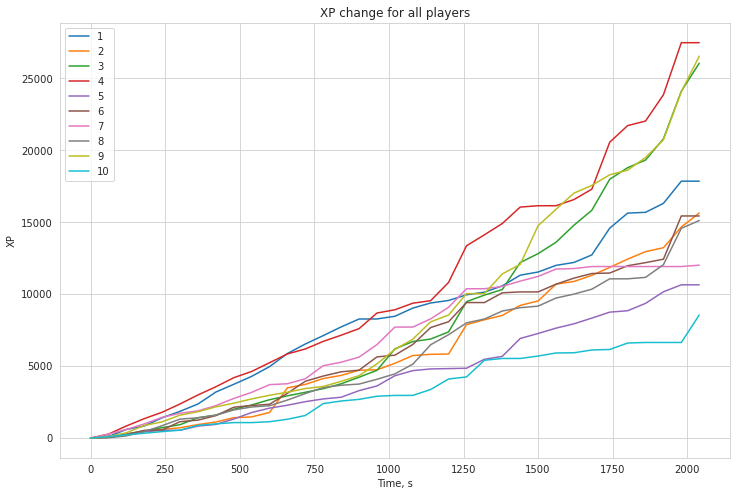

In [16]:
for i, player in enumerate(match["players"]):
    plt.plot(player["times"], player["xp_t"], label=str(i+1))

plt.legend()
plt.xlabel("Time, s")
plt.ylabel("XP")
plt.title("XP change for all players");

#### Сделаем чтение файла с сырыми данными и добавление новых признаков удобным

В этот раз для чтение `json` файлов лучше использовать библиотеку `ujson`, иначе все будет слишком долго :(

In [10]:
try:
    import ujson as json
except ModuleNotFoundError:
    import json
    print ("Подумайте об установке ujson, чтобы работать с JSON объектами быстрее")
    
try:
    from tqdm.notebook import tqdm
except ModuleNotFoundError:
    tqdm_notebook = lambda x: x
    print ("Подумайте об установке tqdm, чтобы следить за прогрессом")

    
def read_matches(matches_file, total_matches=31698, n_matches_to_read=None):
    """
    Аргумент
    -------
    matches_file: JSON файл с сырыми данными
    
    Результат
    ---------
    Возвращает записи о каждом матче
    """
    
    if n_matches_to_read is None:
        n_matches_to_read = total_matches
        
    c = 0
    with open(matches_file) as fin:
        for line in tqdm(fin, total=total_matches):
            if c >= n_matches_to_read:
                break
            else:
                c += 1
                yield json.loads(line)

#### Чтение данных в цикле

Чтение всех данных занимает 1-2 минуты, поэтому для начала можно попробовать следующее:

1. Читать 10-50 игр
2. Написать код для работы с этими JSON объектами
3. Убедиться, что все работает
4. Запустить код на всем датасете
5. Сохранить результат в `pickle` файл, чтобы в следующий раз не переделывать все заново

### #4. <left>Feature engineering

Напишем функцию, которая поможет нам легче добавлять новые признаки. 
Для начала добавим количество захваченных башен, KDA для всех игроков и командное золото.

In [67]:
def add_new_features(df_features, matches_file, n_tot, n_to_read):
    """
    Аргументы
    -------
    df_features: таблица с данными
    matches_file: JSON файл с сырыми данными
    
    Результат
    ---------
    Добавляет новые признаки в таблицу
    """
    
    for match in read_matches(matches_file, total_matches=n_tot, n_matches_to_read=n_to_read):
        match_id_hash = match['match_id_hash']

        # Посчитаем количество разрушенных вышек обеими командами
        radiant_tower_kills = 0
        dire_tower_kills = 0
        for objective in match["objectives"]:
            if objective["type"] == "CHAT_MESSAGE_TOWER_KILL":
                if objective["team"] == 2:
                    radiant_tower_kills += 1
                if objective["team"] == 3:
                    dire_tower_kills += 1

        df_features.loc[match_id_hash, "radiant_tower_kills"] = radiant_tower_kills
        df_features.loc[match_id_hash, "dire_tower_kills"] = dire_tower_kills
        df_features.loc[match_id_hash, "diff_tower_kills"] = radiant_tower_kills - dire_tower_kills
        
        # ... (/¯◡ ‿ ◡)/¯☆*:・ﾟ добавляем новые признаки ...
        
        # Посчитаем KDA игроков, а также количество использованных способностей и предметов (понижают скор), покупок
        for i in range(len(match["players"])):
            player = match["players"][i]
            if player["deaths"] == 0:
                kda = player["kills"] + player["assists"]
            else: 
                kda = (player["kills"] + player["assists"]) / player["deaths"]
                
            tot_abilities = sum(player["ability_uses"].values()) 
            tot_items = sum(player["item_uses"].values()) 
            tot_purchase = len(player['purchase'])
            
            if player['player_slot'] < 100:
                col_name_kda = f'r{i+1}_KDA'
                col_name_items = f'r{i+1}_count_items'
                col_name_abilities = f'r{i+1}_count_abilities'
                col_name_purchase = f'r{i+1}_count_purchase'
            else:
                col_name_kda = f'd{i-4}_KDA'
                col_name_items = f'd{i-4}_count_items'
                col_name_abilities = f'd{i-4}_count_abilities'
                col_name_purchase = f'd{i-4}_count_purchase'

            df_features.loc[match_id_hash, col_name_kda] = kda
            df_features.loc[match_id_hash, col_name_items] = tot_items
            df_features.loc[match_id_hash, col_name_abilities] = tot_abilities
            df_features.loc[match_id_hash, col_name_purchase] = tot_purchase
            
        # Team gold, xp
        r_gold = 0
        r_xp = 0
        r_items = 0
        r_purchase = 0
        r_abilities = 0
        
        for i in range(1, 6):
            gold_col_name = f'r{i}_gold'
            r_gold += df_features.loc[match_id_hash, gold_col_name]
            
            xp_col_name = f'r{i}_xp'
            r_xp += df_features.loc[match_id_hash, xp_col_name]
            
            pur_col_name = f'r{i}_count_purchase'
            r_purchase += df_features.loc[match_id_hash, pur_col_name]
            
            item_col_name = f'r{i}_count_items'
            r_items += df_features.loc[match_id_hash, item_col_name]
            
            abil_col_name = f'r{i}_count_abilities'
            r_abilities += df_features.loc[match_id_hash, abil_col_name]
            
        df_features.loc[match_id_hash, 'r_team_gold'] = r_gold
        df_features.loc[match_id_hash, 'r_team_xp'] = r_xp
        df_features.loc[match_id_hash, 'r_team_purchase'] = r_purchase
        df_features.loc[match_id_hash, 'r_team_items'] = r_items
        df_features.loc[match_id_hash, 'r_team_abilities'] = r_abilities
        
        
        d_gold = 0
        d_xp = 0
        d_items = 0
        d_purchase = 0
        d_abilities = 0
        for i in range(1, 6):
            gold_col_name = f'd{i}_gold'
            d_gold += df_features.loc[match_id_hash, gold_col_name]
            
            xp_col_name = f'd{i}_xp'
            d_xp += df_features.loc[match_id_hash, xp_col_name]
            
            pur_col_name = f'd{i}_count_purchase'
            d_purchase += df_features.loc[match_id_hash, pur_col_name]
            
            item_col_name = f'd{i}_count_items'
            d_items += df_features.loc[match_id_hash, item_col_name]
            
            abil_col_name = f'd{i}_count_abilities'
            d_abilities += df_features.loc[match_id_hash, abil_col_name]
            
        df_features.loc[match_id_hash, 'd_team_gold'] = d_gold
        df_features.loc[match_id_hash, 'd_team_xp'] = d_xp
        df_features.loc[match_id_hash, 'd_team_purchase'] = d_purchase
        df_features.loc[match_id_hash, 'd_team_items'] = d_items
        df_features.loc[match_id_hash, 'd_team_abilities'] = d_abilities
        
        df_features.loc[match_id_hash, 'diff_team_gold'] = r_gold - d_gold
        df_features.loc[match_id_hash, 'diff_team_xp'] = r_xp - d_xp
        df_features.loc[match_id_hash, 'diff_team_purchase'] = r_purchase - d_purchase
        df_features.loc[match_id_hash, 'diff_team_items'] = r_items - d_items
        df_features.loc[match_id_hash, 'diff_team_abilities'] = r_abilities - d_abilities
        
    
        
        

In [12]:
# Скопируем таблицу с признаками
df_train_features_extended = df_train_features.copy()

# Добавим новые
add_new_features(df_train_features_extended, 
                 os.path.join(PATH_TO_DATA, 
                              "train_raw_data.jsonl"))

  0%|          | 0/31698 [00:00<?, ?it/s]

-------------------------

### II. Scikit-learn Random Forest

-------------------------

In [20]:
%%time
cv_scores_base = cross_val_score(rf_model, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)
cv_scores_extended = cross_val_score(rf_model, df_train_features_extended.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)

CPU times: user 54.3 ms, sys: 112 ms, total: 167 ms
Wall time: 1min 33s


In [21]:
print(f"ROC-AUC на кросс-валидации для базовых признаков: {cv_scores_base.mean()}")
print(f"ROC-AUC на кросс-валидации для новых признаков: {cv_scores_extended.mean()}")

ROC-AUC на кросс-валидации для базовых признаков: 0.7859123816496376
ROC-AUC на кросс-валидации для новых признаков: 0.8136552154123897


Удалим скоррелированные столбцы.

In [13]:
drop_cols = []
for i in range(1, 6):
    for team in ('r', 'd'):
        kill_col = f'{team}{i}_kills'
        death_col = f'{team}{i}_deaths'
        assist_col = f'{team}{i}_assists'
        gold_col = f'{team}{i}_gold'
        purchase_col = f'{team}{i}_count_purchase'
        item_col = f'{team}{i}_count_items'
        ab_col = f'{team}{i}_count_abilities'
        drop_cols.extend([kill_col, death_col, assist_col, gold_col, purchase_col, item_col, ab_col])

        

df_train_features_extended = df_train_features_extended.drop(columns=drop_cols)

In [23]:
%%time
cv_scores_extended = cross_val_score(rf_model, df_train_features_extended.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)

CPU times: user 43.9 ms, sys: 16 ms, total: 59.9 ms
Wall time: 44.3 s


In [24]:
print(f"ROC-AUC на кросс-валидации для базовых признаков: {cv_scores_base.mean()}")
print(f"ROC-AUC на кросс-валидации для новых признаков: {cv_scores_extended.mean()}")

ROC-AUC на кросс-валидации для базовых признаков: 0.7859123816496376
ROC-AUC на кросс-валидации для новых признаков: 0.8145788990319673


-----------------------------

### #5. VarianceThreshold

------------------------------

Попробуем удалить квази-постоянные фичи и посмотреть, что получится.

In [12]:
%%time
X_train, X_valid, y_train, y_valid = train_test_split(df_train_features_extended, y, 
                                                      test_size=0.3, 
                                                      random_state=SEED)

CPU times: user 37.6 ms, sys: 4.03 ms, total: 41.7 ms
Wall time: 40 ms


In [13]:
sel = VarianceThreshold(threshold=0.05)

sel.fit(X_train)

VarianceThreshold(threshold=0.05)

In [14]:
sum(sel.get_support())
len(X_train.columns[sel.get_support()])

223

In [15]:
# Давайте посмотрим, какие фичи мы убрали:
print(
    len([
        x for x in X_train.columns
        if x not in X_train.columns[sel.get_support()]
    ]))

[x for x in X_train.columns if x not in X_train.columns[sel.get_support()]]

10


['r1_roshans_killed',
 'r2_roshans_killed',
 'r3_roshans_killed',
 'r4_roshans_killed',
 'r5_roshans_killed',
 'd1_roshans_killed',
 'd2_roshans_killed',
 'd3_roshans_killed',
 'd4_roshans_killed',
 'd5_roshans_killed']

In [14]:
for match in df_train_features_extended.index:
    for team in ('r', 'd'):
        team_col = f'{team}_roshans_killed' 
        k = 0
        for i in range(1, 6):
            kill_col_name = f'{team}{i}_roshans_killed'
            k += df_train_features_extended.loc[match, kill_col_name]

        df_train_features_extended.loc[match, team_col] = k

In [17]:
df_train_features_extended

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_denies,r1_lh,r1_xp,r1_health,...,d_team_purchase,d_team_items,d_team_abilities,diff_team_gold,diff_team_xp,diff_team_purchase,diff_team_items,diff_team_abilities,r_roshans_killed,d_roshans_killed
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,52,3937,1160,...,65.0,67.0,102.0,5028.0,4641.0,8.0,36.0,-8.0,0.0,0.0
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,680,...,18.0,1.0,1.0,400.0,0.0,2.0,-1.0,0.0,0.0,0.0
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,57,1,0,359,740,...,28.0,8.0,4.0,1104.0,429.0,4.0,-3.0,6.0,0.0,0.0
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,119,5,1,2828,495,...,68.0,96.0,161.0,2831.0,-1225.0,8.0,34.0,25.0,0.0,0.0
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,12,9,40,3964,495,...,62.0,55.0,61.0,-790.0,-554.0,8.0,40.0,79.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b794aa55646841a03c7783226e6f6bc8,2666,22,0,23,8,99,3,251,25448,0,...,158.0,504.0,785.0,-13706.0,-10136.0,-14.0,-204.0,358.0,0.0,2.0
308faee28efee2e66b39f9f2ba6ea9cf,2525,22,0,15,5,22,3,151,19592,1478,...,119.0,396.0,490.0,12231.0,18717.0,3.0,152.0,-37.0,1.0,1.0
6066cc7417b43c749d551e123d00f0c8,1002,4,0,4,0,1,0,59,4478,880,...,70.0,112.0,220.0,-4448.0,-4359.0,-13.0,-53.0,-74.0,0.0,0.0


In [18]:
%%time
cv_scores_extended = cross_val_score(rf_model, df_train_features_extended.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)

CPU times: user 50 ms, sys: 140 ms, total: 190 ms
Wall time: 42.3 s


In [19]:
print(f"ROC-AUC на кросс-валидации для новых признаков: {cv_scores_extended.mean()}")

ROC-AUC на кросс-валидации для новых признаков: 0.8142492907766699


In [15]:
df_train_features_extended.loc[:, 'diff_roshans_killed'] = df_train_features_extended.loc[:, 'r_roshans_killed'] - df_train_features_extended.loc[:, 'd_roshans_killed']
df_train_features_extended

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_denies,r1_lh,r1_xp,r1_health,...,d_team_items,d_team_abilities,diff_team_gold,diff_team_xp,diff_team_purchase,diff_team_items,diff_team_abilities,r_roshans_killed,d_roshans_killed,diff_roshans_killed
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,52,3937,1160,...,67.0,102.0,5028.0,4641.0,8.0,36.0,-8.0,0.0,0.0,0.0
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,680,...,1.0,1.0,400.0,0.0,2.0,-1.0,0.0,0.0,0.0,0.0
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,57,1,0,359,740,...,8.0,4.0,1104.0,429.0,4.0,-3.0,6.0,0.0,0.0,0.0
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,119,5,1,2828,495,...,96.0,161.0,2831.0,-1225.0,8.0,34.0,25.0,0.0,0.0,0.0
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,12,9,40,3964,495,...,55.0,61.0,-790.0,-554.0,8.0,40.0,79.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b794aa55646841a03c7783226e6f6bc8,2666,22,0,23,8,99,3,251,25448,0,...,504.0,785.0,-13706.0,-10136.0,-14.0,-204.0,358.0,0.0,2.0,-2.0
308faee28efee2e66b39f9f2ba6ea9cf,2525,22,0,15,5,22,3,151,19592,1478,...,396.0,490.0,12231.0,18717.0,3.0,152.0,-37.0,1.0,1.0,0.0
6066cc7417b43c749d551e123d00f0c8,1002,4,0,4,0,1,0,59,4478,880,...,112.0,220.0,-4448.0,-4359.0,-13.0,-53.0,-74.0,0.0,0.0,0.0


In [16]:
%%time
cv_scores_extended = cross_val_score(rf_model, df_train_features_extended.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)

CPU times: user 61.2 ms, sys: 100 ms, total: 161 ms
Wall time: 40.8 s


In [17]:
print(f"ROC-AUC на кросс-валидации для новых признаков: {cv_scores_extended.mean()}")

ROC-AUC на кросс-валидации для новых признаков: 0.8143244595639768


---------------------------------------
### #6. Boruta
-----------------------------------

Посмотрим, какие фичи вносят наибольший вклад.

In [18]:
from boruta import BorutaPy

In [19]:
boruta_selector = BorutaPy(RandomForestClassifier(n_estimators=500, max_depth=None, n_jobs=1, random_state=SEED),
                           n_estimators='auto', verbose=2, max_iter=28, random_state=SEED)

In [20]:
%%time
boruta_selector.fit(df_train_features_extended.values, y)

Iteration: 	1 / 28
Confirmed: 	0
Tentative: 	236
Rejected: 	0
Iteration: 	2 / 28
Confirmed: 	0
Tentative: 	236
Rejected: 	0
Iteration: 	3 / 28
Confirmed: 	0
Tentative: 	236
Rejected: 	0
Iteration: 	4 / 28
Confirmed: 	0
Tentative: 	236
Rejected: 	0
Iteration: 	5 / 28
Confirmed: 	0
Tentative: 	236
Rejected: 	0
Iteration: 	6 / 28
Confirmed: 	0
Tentative: 	236
Rejected: 	0
Iteration: 	7 / 28
Confirmed: 	0
Tentative: 	236
Rejected: 	0
Iteration: 	8 / 28
Confirmed: 	40
Tentative: 	6
Rejected: 	190
Iteration: 	9 / 28
Confirmed: 	40
Tentative: 	6
Rejected: 	190
Iteration: 	10 / 28
Confirmed: 	40
Tentative: 	6
Rejected: 	190
Iteration: 	11 / 28
Confirmed: 	40
Tentative: 	6
Rejected: 	190
Iteration: 	12 / 28
Confirmed: 	40
Tentative: 	6
Rejected: 	190
Iteration: 	13 / 28
Confirmed: 	40
Tentative: 	4
Rejected: 	192
Iteration: 	14 / 28
Confirmed: 	40
Tentative: 	4
Rejected: 	192
Iteration: 	15 / 28
Confirmed: 	40
Tentative: 	4
Rejected: 	192
Iteration: 	16 / 28
Confirmed: 	40
Tentative: 	4
Rejecte

BorutaPy(estimator=RandomForestClassifier(n_estimators=91, n_jobs=1,
                                          random_state=RandomState(MT19937) at 0x7FD2721E1840),
         max_iter=28, n_estimators='auto',
         random_state=RandomState(MT19937) at 0x7FD2721E1840, verbose=2)

In [21]:
feature_df = pd.DataFrame(df_train_features_extended.columns.tolist(), columns=['features'])
feature_df['rank']=boruta_selector.ranking_
feature_df = feature_df.sort_values('rank', ascending=True).reset_index(drop=True)

print ('\n Top %d features:' % boruta_selector.n_features_)
print (feature_df.head(boruta_selector.n_features_))



 Top 40 features:
               features  rank
0                  r3_x     1
1                d3_KDA     1
2       d_team_purchase     1
3                d4_KDA     1
4                  r5_y     1
5                  r5_x     1
6                  d4_y     1
7                  r3_y     1
8                  d1_y     1
9                  d4_x     1
10               r1_KDA     1
11     diff_tower_kills     1
12                 r2_x     1
13                 r2_y     1
14     dire_tower_kills     1
15          d_team_gold     1
16               d5_KDA     1
17               r2_KDA     1
18                 d2_y     1
19       diff_team_gold     1
20               d2_KDA     1
21                 r4_x     1
22      diff_team_items     1
23                 r4_y     1
24                 d3_y     1
25               r3_KDA     1
26                 d3_x     1
27               r4_KDA     1
28               r5_KDA     1
29               d1_KDA     1
30                 d2_x     1
31                 d5

Кажется, стоит попробовать как-то изменить координаты.

----------------------

### III. XGB random forest

---------------------

Для начала найдём лучшие параметры с помощью `GridSearchCV`.

In [47]:
xgb_rf_clf = xgboost.XGBRFClassifier(subsample=0.7, random_state=SEED, n_jobs=1)

In [82]:
xgbrf_params = {'n_estimators': [300, 500, 800, 1000],
                'colsample_bynode': [0.2, 0.4, 0.8],
                 'max_depth': [2, 5, 7, 12, 15]
                }


grid_xgbrf = GridSearchCV(xgb_rf_clf, param_grid=xgbrf_params, cv=5, scoring='roc_auc')

In [85]:
grid_xgbrf.predict(X_valid)

array([1, 0, 0, ..., 1, 0, 1], dtype=int8)

In [86]:
grid_xgbrf.best_score_, grid_xgbrf.best_params_

(0.8134092470898807,
 {'colsample_bynode': 0.2, 'max_depth': 15, 'n_estimators': 1000})

In [22]:
# xgb_rf_clf = xgboost.XGBRFClassifier(n_estimators=1000, subsample=0.7, max_depth=15, colsample_bynode=0.2, random_state=SEED, n_jobs=1, verbosity=2, tree_method='gpu_hist')
# сохранила на случай, если пойду запускать в колаб.


xgb_rf_clf = xgboost.XGBRFClassifier(n_estimators=1000, subsample=0.7, max_depth=15, colsample_bynode=0.2, random_state=SEED, n_jobs=1, verbosity=2)

In [23]:
%%time
cv = ShuffleSplit(n_splits=3, test_size=0.3, random_state=SEED)
# cv_scores_base = cross_val_score(xgb_rf_clf, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)
cv_scores_extended_xgb_rf = cross_val_score(xgb_rf_clf, df_train_features_extended.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=1)

[21:00:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2464 extra nodes, 0 pruned nodes, max_depth=15
[21:00:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2486 extra nodes, 0 pruned nodes, max_depth=15
[21:00:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2270 extra nodes, 0 pruned nodes, max_depth=15
[21:00:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2366 extra nodes, 0 pruned nodes, max_depth=15
[21:00:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2228 extra nodes, 0 pruned nodes, max_depth=15
[21:00:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2606 extra nodes, 0 pruned nodes, max_depth=15
[21:00:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2458 extra nodes, 0 pruned nodes, max_depth=15
[21:00:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2432 extra nodes, 0 pruned nodes, max_depth=15
[21:00:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 199

[21:04:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2410 extra nodes, 0 pruned nodes, max_depth=15
[21:04:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2366 extra nodes, 0 pruned nodes, max_depth=15
[21:04:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2396 extra nodes, 0 pruned nodes, max_depth=15
[21:04:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2054 extra nodes, 0 pruned nodes, max_depth=15
[21:04:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2208 extra nodes, 0 pruned nodes, max_depth=15
[21:04:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2602 extra nodes, 0 pruned nodes, max_depth=15
[21:04:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2134 extra nodes, 0 pruned nodes, max_depth=15
[21:04:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2212 extra nodes, 0 pruned nodes, max_depth=15
[21:04:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 193

[21:07:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2436 extra nodes, 0 pruned nodes, max_depth=15
[21:07:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2356 extra nodes, 0 pruned nodes, max_depth=15
[21:07:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2178 extra nodes, 0 pruned nodes, max_depth=15
[21:07:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2124 extra nodes, 0 pruned nodes, max_depth=15
[21:07:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2234 extra nodes, 0 pruned nodes, max_depth=15
[21:07:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2624 extra nodes, 0 pruned nodes, max_depth=15
[21:07:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2172 extra nodes, 0 pruned nodes, max_depth=15
[21:07:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2348 extra nodes, 0 pruned nodes, max_depth=15
[21:07:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 205

CPU times: user 11min 22s, sys: 1.15 s, total: 11min 23s
Wall time: 11min 26s


In [24]:
print(f"ROC-AUC на кросс-валидации для новых признаков: {cv_scores_extended_xgb_rf.mean()}")

ROC-AUC на кросс-валидации для новых признаков: 0.8163926891056881


Пока лучший результат.


-----------------

### #4. Hero win rate encoding

--------------------

Закодируем для каждого id героя отношение его побед к общему число матчей, в котором он играл.

In [30]:
df_train_features_extended

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_denies,r1_lh,r1_xp,r1_health,...,d_team_items,d_team_abilities,diff_team_gold,diff_team_xp,diff_team_purchase,diff_team_items,diff_team_abilities,r_roshans_killed,d_roshans_killed,diff_roshans_killed
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,52,3937,1160,...,67.0,102.0,5028.0,4641.0,8.0,36.0,-8.0,0.0,0.0,0.0
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,680,...,1.0,1.0,400.0,0.0,2.0,-1.0,0.0,0.0,0.0,0.0
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,57,1,0,359,740,...,8.0,4.0,1104.0,429.0,4.0,-3.0,6.0,0.0,0.0,0.0
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,119,5,1,2828,495,...,96.0,161.0,2831.0,-1225.0,8.0,34.0,25.0,0.0,0.0,0.0
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,12,9,40,3964,495,...,55.0,61.0,-790.0,-554.0,8.0,40.0,79.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b794aa55646841a03c7783226e6f6bc8,2666,22,0,23,8,99,3,251,25448,0,...,504.0,785.0,-13706.0,-10136.0,-14.0,-204.0,358.0,0.0,2.0,-2.0
308faee28efee2e66b39f9f2ba6ea9cf,2525,22,0,15,5,22,3,151,19592,1478,...,396.0,490.0,12231.0,18717.0,3.0,152.0,-37.0,1.0,1.0,0.0
6066cc7417b43c749d551e123d00f0c8,1002,4,0,4,0,1,0,59,4478,880,...,112.0,220.0,-4448.0,-4359.0,-13.0,-53.0,-74.0,0.0,0.0,0.0


In [31]:
j = 0
hero_id_win_rate = {i: 0 for i in range(1, 121)}
hero_id_in_match = {i: 0 for i in range(1, 121)}
for match in df_train_features_extended.index:
    for i in range(1, 6):
        for team in ('r', 'd'):
            col_name = f'{team}{i}_hero_id'
            hero_id_in_match[df_train_features_extended.loc[match, col_name]] += 1
            if y[j] == 1:
                hero_id_win_rate[df_train_features_extended.loc[match, col_name]] += 1
    j += 1

for i in range(1, 121):
    if hero_id_in_match[i] != 0:
        hero_id_win_rate[i] /= hero_id_in_match[i]

for i in range(1, 6):
    for team in ('r', 'd'):
        hero_id = f'{team}{i}_hero_id'
        new_col_name = f'{team}{i}_hero_win_rate'
        df_train_features_extended = df_train_features_extended.replace({hero_id: hero_id_win_rate})
        df_train_features_extended.rename(columns = {hero_id: new_col_name}, inplace = True)

In [32]:
df_train_features_extended

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_win_rate,r1_denies,r1_lh,r1_xp,r1_health,...,d_team_items,d_team_abilities,diff_team_gold,diff_team_xp,diff_team_purchase,diff_team_items,diff_team_abilities,r_roshans_killed,d_roshans_killed,diff_roshans_killed
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,0.487003,7,52,3937,1160,...,67.0,102.0,5028.0,4641.0,8.0,36.0,-8.0,0.0,0.0,0.0
6db558535151ea18ca70a6892197db41,21,23,0,0,0,0.524348,0,0,0,680,...,1.0,1.0,400.0,0.0,2.0,-1.0,0.0,0.0,0.0,0.0
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,0.519692,1,0,359,740,...,8.0,4.0,1104.0,429.0,4.0,-3.0,6.0,0.0,0.0,0.0
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,0.526177,5,1,2828,495,...,96.0,161.0,2831.0,-1225.0,8.0,34.0,25.0,0.0,0.0,0.0
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,0.519652,9,40,3964,495,...,55.0,61.0,-790.0,-554.0,8.0,40.0,79.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b794aa55646841a03c7783226e6f6bc8,2666,22,0,23,8,0.509217,3,251,25448,0,...,504.0,785.0,-13706.0,-10136.0,-14.0,-204.0,358.0,0.0,2.0,-2.0
308faee28efee2e66b39f9f2ba6ea9cf,2525,22,0,15,5,0.525938,3,151,19592,1478,...,396.0,490.0,12231.0,18717.0,3.0,152.0,-37.0,1.0,1.0,0.0
6066cc7417b43c749d551e123d00f0c8,1002,4,0,4,0,0.524172,0,59,4478,880,...,112.0,220.0,-4448.0,-4359.0,-13.0,-53.0,-74.0,0.0,0.0,0.0


-------------------------

### #7. X and Y to distance

-------------------------

$$ distance = \sqrt{x^2 + y^2}$$

In [33]:
for match in df_train_features_extended.index:
    for i in range(1, 6):
        for team in ('r', 'd'):
            x_col_name = f'{team}{i}_x'
            y_col_name = f'{team}{i}_y'

            dist = np.sqrt( df_train_features_extended.loc[match, x_col_name] ** 2 +
                           df_train_features_extended.loc[match, y_col_name] ** 2 )

            dist_col_name = f'{team}{i}_dist'
            df_train_features_extended.loc[match, dist_col_name] = dist

In [88]:
for i in df_train_features_extended.columns:
    print(i)

game_time
game_mode
lobby_type
objectives_len
chat_len
r1_hero_win_rate
r1_denies
r1_lh
r1_xp
r1_health
r1_max_health
r1_max_mana
r1_level
r1_x
r1_y
r1_stuns
r1_creeps_stacked
r1_camps_stacked
r1_rune_pickups
r1_firstblood_claimed
r1_teamfight_participation
r1_towers_killed
r1_roshans_killed
r1_obs_placed
r1_sen_placed
r2_hero_win_rate
r2_denies
r2_lh
r2_xp
r2_health
r2_max_health
r2_max_mana
r2_level
r2_x
r2_y
r2_stuns
r2_creeps_stacked
r2_camps_stacked
r2_rune_pickups
r2_firstblood_claimed
r2_teamfight_participation
r2_towers_killed
r2_roshans_killed
r2_obs_placed
r2_sen_placed
r3_hero_win_rate
r3_denies
r3_lh
r3_xp
r3_health
r3_max_health
r3_max_mana
r3_level
r3_x
r3_y
r3_stuns
r3_creeps_stacked
r3_camps_stacked
r3_rune_pickups
r3_firstblood_claimed
r3_teamfight_participation
r3_towers_killed
r3_roshans_killed
r3_obs_placed
r3_sen_placed
r4_hero_win_rate
r4_denies
r4_lh
r4_xp
r4_health
r4_max_health
r4_max_mana
r4_level
r4_x
r4_y
r4_stuns
r4_creeps_stacked
r4_camps_stacked
r4_rune_p

#### sklearn random forest:

In [35]:
cv_scores_extended_rf = cross_val_score(rf_model, df_train_features_extended.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)

In [36]:
print(f"ROC-AUC на кросс-валидации для новых признаков: {cv_scores_extended_rf.mean()}")

ROC-AUC на кросс-валидации для новых признаков: 0.8126185573771736


#### xgboost random forest

In [52]:
%%time
cv_scores_extended_xgb_rf_2 = cross_val_score(xgb_rf_clf, df_train_features_extended.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=1)

[21:59:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2596 extra nodes, 0 pruned nodes, max_depth=15
[21:59:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2110 extra nodes, 0 pruned nodes, max_depth=15
[21:59:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2228 extra nodes, 0 pruned nodes, max_depth=15
[21:59:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2518 extra nodes, 0 pruned nodes, max_depth=15
[21:59:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2400 extra nodes, 0 pruned nodes, max_depth=15
[21:59:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2254 extra nodes, 0 pruned nodes, max_depth=15
[21:59:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2388 extra nodes, 0 pruned nodes, max_depth=15
[21:59:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2302 extra nodes, 0 pruned nodes, max_depth=15
[21:59:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208

[22:03:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2442 extra nodes, 0 pruned nodes, max_depth=15
[22:03:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2014 extra nodes, 0 pruned nodes, max_depth=15
[22:03:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2282 extra nodes, 0 pruned nodes, max_depth=15
[22:03:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2330 extra nodes, 0 pruned nodes, max_depth=15
[22:03:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2330 extra nodes, 0 pruned nodes, max_depth=15
[22:03:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2204 extra nodes, 0 pruned nodes, max_depth=15
[22:03:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2342 extra nodes, 0 pruned nodes, max_depth=15
[22:03:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2516 extra nodes, 0 pruned nodes, max_depth=15
[22:03:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 220

[22:07:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2482 extra nodes, 0 pruned nodes, max_depth=15
[22:07:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2284 extra nodes, 0 pruned nodes, max_depth=15
[22:07:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2314 extra nodes, 0 pruned nodes, max_depth=15
[22:07:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2350 extra nodes, 0 pruned nodes, max_depth=15
[22:07:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2202 extra nodes, 0 pruned nodes, max_depth=15
[22:07:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2150 extra nodes, 0 pruned nodes, max_depth=15
[22:07:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2318 extra nodes, 0 pruned nodes, max_depth=15
[22:07:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2234 extra nodes, 0 pruned nodes, max_depth=15
[22:07:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204

[22:12:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2374 extra nodes, 0 pruned nodes, max_depth=15
[22:12:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2054 extra nodes, 0 pruned nodes, max_depth=15
[22:12:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1920 extra nodes, 0 pruned nodes, max_depth=15
[22:12:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2296 extra nodes, 0 pruned nodes, max_depth=15
[22:12:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2278 extra nodes, 0 pruned nodes, max_depth=15
[22:12:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1998 extra nodes, 0 pruned nodes, max_depth=15
[22:12:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2314 extra nodes, 0 pruned nodes, max_depth=15
[22:12:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2376 extra nodes, 0 pruned nodes, max_depth=15
[22:12:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 211

[22:16:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2370 extra nodes, 0 pruned nodes, max_depth=15
[22:16:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2288 extra nodes, 0 pruned nodes, max_depth=15
[22:16:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2154 extra nodes, 0 pruned nodes, max_depth=15
[22:16:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2276 extra nodes, 0 pruned nodes, max_depth=15
[22:16:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2084 extra nodes, 0 pruned nodes, max_depth=15
[22:16:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2282 extra nodes, 0 pruned nodes, max_depth=15
[22:16:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2312 extra nodes, 0 pruned nodes, max_depth=15
[22:16:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2336 extra nodes, 0 pruned nodes, max_depth=15
[22:16:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 189

CPU times: user 20min 18s, sys: 2.26 s, total: 20min 20s
Wall time: 20min 22s


In [53]:
print(f"ROC-AUC на кросс-валидации для новых признаков: {cv_scores_extended_xgb_rf_2.mean()}")

ROC-AUC на кросс-валидации для новых признаков: 0.816679320863761


Как-то так.

------------------------------------
### IV. SVC 
------------------------------------

In [26]:
svc_pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('svc', SVC(max_iter=10000))
])

In [27]:
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=SEED)

In [ ]:
cv_scores_extended = cross_val_score(svc_pipe, df_train_features_extended.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)

In [29]:
print(f"ROC-AUC на кросс-валидации для новых признаков: {cv_scores_extended.mean()}")

ROC-AUC на кросс-валидации для новых признаков: 0.8018078670157642


Выберем гиперпараметры.

In [49]:
svc_params = {'svc__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                'svc__gamma': ['scale', 'auto']
                }


grid_scv = GridSearchCV(svc_pipe, param_grid=svc_params, cv=cv, scoring='roc_auc', n_jobs=-1)

In [50]:
grid_scv.fit(df_train_features_extended, y)

/home/oxalotl/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/oxalotl/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/oxalotl/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/oxalotl/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/oxalotl/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:284: C

GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=10801, test_size=0.3, train_size=None),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('svc', SVC(max_iter=10000))]),
             n_jobs=-1,
             param_grid={'svc__gamma': ['scale', 'auto'],
                         'svc__kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             scoring='roc_auc')

In [51]:
grid_scv.best_score_, grid_scv.best_params_

(0.8036214610720064, {'svc__gamma': 'scale', 'svc__kernel': 'rbf'})

С учётом лучших параметров:

In [54]:
svc_pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('svc', SVC(max_iter=10000, kernel='rbf', gamma='scale'))
])

In [55]:
cv_scores_extended_svc = cross_val_score(svc_pipe, df_train_features_extended.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)

/home/oxalotl/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/oxalotl/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/oxalotl/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/oxalotl/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/oxalotl/miniconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:284: C

In [56]:
print(f"ROC-AUC на кросс-валидации для новых признаков: {cv_scores_extended_svc.mean()}")

ROC-AUC на кросс-валидации для новых признаков: 0.8036214610720064


----------------------------------------------------------------


### V. Linear regression


-----------------------------------------------------------------

Подготовим пайплайн для стандартизации и логистической регрессии.

In [37]:
logreg_pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(multi_class='ovr', max_iter=10000))
])

Найдём лучшие параметры.

In [39]:
logreg_params = {'logreg__penalty': ['l1', 'l2'],
                'logreg__solver': ['liblinear', 'saga']
                }


grid_logreg = GridSearchCV(logreg_pipe, param_grid=logreg_params, cv=cv, scoring='roc_auc', n_jobs=-1)

In [40]:
%%time
grid_logreg.fit(df_train_features_extended, y)

CPU times: user 14 s, sys: 336 ms, total: 14.4 s
Wall time: 1min 10s


GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=10801, test_size=0.3, train_size=None),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('logreg',
                                        LogisticRegression(max_iter=10000,
                                                           multi_class='ovr'))]),
             n_jobs=-1,
             param_grid={'logreg__penalty': ['l1', 'l2'],
                         'logreg__solver': ['liblinear', 'saga']},
             scoring='roc_auc')

In [41]:
grid_logreg.predict(df_train_features_extended)
grid_logreg.best_score_, grid_logreg.best_params_ 

(0.8113592652613729, {'logreg__penalty': 'l1', 'logreg__solver': 'liblinear'})

С учётом лучших параметров:

In [42]:
logreg_pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(multi_class='ovr', penalty='l1', solver='liblinear', max_iter=10000))
])

In [43]:
%%time
cv_scores_base_lr = cross_val_score(logreg_pipe, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)
cv_scores_extended_lr = cross_val_score(logreg_pipe, df_train_features_extended.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)

CPU times: user 150 ms, sys: 777 ms, total: 927 ms
Wall time: 43.4 s


In [44]:
print(f"ROC-AUC на кросс-валидации для базовых признаков: {cv_scores_base_lr.mean()}")
print(f"ROC-AUC на кросс-валидации для новых признаков: {cv_scores_extended_lr.mean()}")

ROC-AUC на кросс-валидации для базовых признаков: 0.8071323193676765
ROC-AUC на кросс-валидации для новых признаков: 0.8113582202389003


### GaussianNB

In [45]:
from sklearn.naive_bayes import GaussianNB

In [92]:
nb_classifier = GaussianNB()

params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}
gs_NB = GridSearchCV(estimator=nb_classifier, 
                 param_grid=params_NB, 
                 cv=cv,  
                 verbose=1, 
                 scoring='roc_auc') 
gs_NB.fit(X, y)

gs_NB.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


{'var_smoothing': 1e-09}

In [93]:
gs_NB.best_score_

0.7299048386590282

In [46]:
nb = GaussianNB(var_smoothing=10**(-9))

In [47]:
%%time
cv_scores_extended_nb = cross_val_score(nb, df_train_features_extended.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)

CPU times: user 25.9 ms, sys: 24 ms, total: 49.9 ms
Wall time: 742 ms


In [48]:
print(f"ROC-AUC на кросс-валидации для новых признаков: {cv_scores_extended_nb.mean()}")

ROC-AUC на кросс-валидации для новых признаков: 0.7690734882599004


Хуже, что у остальных моделей.

### Конец.

Лучший результат показал XGBoost RandomForest.  
Обучим эту модель и подготовим тестовые файлы к предсказанию.

In [63]:
xgb_rf_clf.fit(df_train_features_extended, y)

[22:42:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3210 extra nodes, 0 pruned nodes, max_depth=15
[22:42:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3118 extra nodes, 0 pruned nodes, max_depth=15
[22:42:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3166 extra nodes, 0 pruned nodes, max_depth=15
[22:42:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3168 extra nodes, 0 pruned nodes, max_depth=15
[22:42:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3104 extra nodes, 0 pruned nodes, max_depth=15
[22:42:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2912 extra nodes, 0 pruned nodes, max_depth=15
[22:42:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3070 extra nodes, 0 pruned nodes, max_depth=15
[22:42:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2830 extra nodes, 0 pruned nodes, max_depth=15
[22:42:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 282

XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bynode=0.2, colsample_bytree=1,
                enable_categorical=False, gamma=0, gpu_id=-1,
                importance_type=None, interaction_constraints='',
                max_delta_step=0, max_depth=15, min_child_weight=1, missing=nan,
                monotone_constraints='()', n_estimators=1000, n_jobs=1,
                num_parallel_tree=1000, objective='binary:logistic',
                predictor='auto', random_state=10801, reg_alpha=0,
                scale_pos_weight=1, subsample=0.7, tree_method='exact',
                validate_parameters=1, verbosity=2)

In [93]:
df_test_features = pd.read_csv(os.path.join(PATH_TO_DATA, "test_data.csv"), 
                                   index_col="match_id_hash")

# #4.
add_new_features(df_test_features, 
                 os.path.join(PATH_TO_DATA, 
                              "test_raw_data.jsonl"), n_tot=7977, n_to_read=7977)

  0%|          | 0/7977 [00:00<?, ?it/s]

In [94]:
df_test_features

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d_team_gold,d_team_xp,d_team_purchase,d_team_items,d_team_abilities,diff_team_gold,diff_team_xp,diff_team_purchase,diff_team_items,diff_team_abilities
match_id_hash,,,,,,,,,,,,,,,,,,,,,
a400b8f29dece5f4d266f49f1ae2e98a,155,22,7,1,11,11,0,0,0,0,...,3948.0,3084.0,33.0,12.0,11.0,-1911.0,-1093.0,-3.0,8.0,-4.0
46a0ddce8f7ed2a8d9bd5edcbb925682,576,22,7,1,4,14,1,0,3,1,...,11301.0,11843.0,50.0,65.0,82.0,2047.0,2820.0,7.0,-3.0,33.0
b1b35ff97723d9b7ade1c9c3cf48f770,453,22,7,1,3,42,0,1,1,0,...,9177.0,10806.0,31.0,35.0,70.0,-1098.0,-1044.0,6.0,13.0,17.0
ab3cc6ccac661a1385e73a2e9f21313a,721,4,0,2,1,30,2,2,1,3,...,16232.0,16521.0,69.0,97.0,101.0,928.0,1199.0,-9.0,-7.0,128.0
54aaab1cb8cc5df3c253641618673266,752,22,7,1,0,8,2,0,2,8,...,15770.0,18845.0,68.0,67.0,162.0,1348.0,1179.0,5.0,7.0,-7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
03f683fed8cf6f03b735e2ee2a942698,509,4,0,1,0,16,2,0,0,1,...,9452.0,10961.0,41.0,68.0,56.0,2614.0,2270.0,7.0,-20.0,-5.0
06e2b42495855647830ccc6d466f913c,2561,22,7,17,7,76,2,9,1,6,...,85110.0,110982.0,143.0,331.0,534.0,-3996.0,-11724.0,-32.0,-69.0,169.0
defd0caeed6ea83d7d5fbdec013fe7d1,1783,22,0,8,23,3,1,9,9,0,...,51638.0,65289.0,107.0,213.0,375.0,-3308.0,-7733.0,-4.0,11.0,899.0


In [95]:
drop_cols = []
for i in range(1, 6):
    for team in ('r', 'd'):
        kill_col = f'{team}{i}_kills'
        death_col = f'{team}{i}_deaths'
        assist_col = f'{team}{i}_assists'
        gold_col = f'{team}{i}_gold'
        purchase_col = f'{team}{i}_count_purchase'
        item_col = f'{team}{i}_count_items'
        ab_col = f'{team}{i}_count_abilities'
        drop_cols.extend([kill_col, death_col, assist_col, gold_col, purchase_col, item_col, ab_col])

        
df_test_features = df_test_features.drop(columns=drop_cols)

# #5. 
for match in df_test_features.index:
    for team in ('r', 'd'):
        team_col = f'{team}_roshans_killed' 
        k = 0
        for i in range(1, 6):
            kill_col_name = f'{team}{i}_roshans_killed'
            k += df_test_features.loc[match, kill_col_name]

        df_test_features.loc[match, team_col] = k

df_test_features.loc[:, 'diff_roshans_killed'] = df_test_features.loc[:, 'r_roshans_killed'] - df_test_features.loc[:, 'd_roshans_killed']        

# #6. win rate 
j = 0
hero_id_win_rate = {i: 0 for i in range(1, 121)}
hero_id_in_match = {i: 0 for i in range(1, 121)}
for match in df_test_features.index:
    for i in range(1, 6):
        for team in ('r', 'd'):
            col_name = f'{team}{i}_hero_id'
            hero_id_in_match[df_test_features.loc[match, col_name]] += 1
            if y[j] == 1:
                hero_id_win_rate[df_test_features.loc[match, col_name]] += 1
    j += 1

for i in range(1, 121):
    if hero_id_in_match[i] != 0:
        hero_id_win_rate[i] /= hero_id_in_match[i]

for i in range(1, 6):
    for team in ('r', 'd'):
        hero_id = f'{team}{i}_hero_id'
        new_col_name = f'{team}{i}_hero_win_rate'
        df_test_features = df_test_features.replace({hero_id: hero_id_win_rate})
        df_test_features.rename(columns = {hero_id: new_col_name}, inplace = True)   
        

# #7. distances 
for match in df_test_features.index:
    for i in range(1, 6):
        for team in ('r', 'd'):
            x_col_name = f'{team}{i}_x'
            y_col_name = f'{team}{i}_y'

            dist = np.sqrt(df_test_features.loc[match, x_col_name] ** 2 +
                           df_test_features.loc[match, y_col_name] ** 2 )

            dist_col_name = f'{team}{i}_dist'
            df_test_features.loc[match, dist_col_name] = dist      
        
        


In [96]:
df_test_features

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_win_rate,r1_denies,r1_lh,r1_xp,r1_health,...,r1_dist,d1_dist,r2_dist,d2_dist,r3_dist,d3_dist,r4_dist,d4_dist,r5_dist,d5_dist
match_id_hash,,,,,,,,,,,,,,,,,,,,,
a400b8f29dece5f4d266f49f1ae2e98a,155,22,7,1,11,0.524744,0,7,533,358,...,168.344884,188.743212,176.782352,195.897933,170.985379,198.635344,190.515091,174.928557,156.204994,181.019336
46a0ddce8f7ed2a8d9bd5edcbb925682,576,22,7,1,4,0.523177,1,0,1471,900,...,195.233194,183.847763,174.470628,189.842040,179.610690,178.000000,182.877008,202.425295,199.529446,179.788765
b1b35ff97723d9b7ade1c9c3cf48f770,453,22,7,1,3,0.507463,0,9,1351,1000,...,182.471916,189.620674,183.412104,203.744939,171.125685,179.610690,166.973052,206.494552,200.688814,192.509740
ab3cc6ccac661a1385e73a2e9f21313a,721,4,0,2,1,0.523023,3,6,3088,704,...,184.390889,184.195548,182.471916,194.092761,172.534055,216.379297,182.482876,190.588562,182.778555,191.415778
54aaab1cb8cc5df3c253641618673266,752,22,7,1,0,0.517467,8,46,5081,1018,...,184.878338,173.066461,166.901168,196.946693,179.799889,254.574154,179.777640,169.729196,169.068034,184.260685
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
03f683fed8cf6f03b735e2ee2a942698,509,4,0,1,0,0.542156,1,16,2794,781,...,174.413302,198.715878,184.010869,194.617574,197.200406,180.676506,194.905105,173.066461,173.954017,202.829978
06e2b42495855647830ccc6d466f913c,2561,22,7,17,7,0.515116,6,46,9094,1360,...,104.690019,183.934771,128.405607,129.274901,137.010948,253.242966,160.897483,183.847763,156.780101,237.587878
defd0caeed6ea83d7d5fbdec013fe7d1,1783,22,0,8,23,0.500000,0,13,7847,0,...,175.316856,166.012048,106.075445,146.492321,170.891779,205.601556,175.316856,147.146186,196.580772,150.585524


### #8.<left>Посылка

In [99]:
X_test = df_test_features.values
y_test_pred = xgb_rf_clf.predict_proba(X_test)[:, 1]

df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred}, 
                                 index=df_test_features.index)

In [100]:
PATH_TO_DATA = "data/processed_data"
submission_filename = "submission_{}.csv".format(
    datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
df_submission.to_csv(os.path.join(PATH_TO_DATA, submission_filename))
print("Файл посылки сохранен, как: {}".format(submission_filename))

Файл посылки сохранен, как: submission_2022-04-03_23-05-22.csv


--------------------------------

--------------------------------

--------------------------------

--------------------------------
--------------------------------

--------------------------------